In [1]:
!pip install clickhouse-driver

In [ ]:
pip install tsfresh

In [8]:
from clickhouse_driver import Client
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM, GRU, Input, concatenate, Activation
from tensorflow.keras.optimizers import SGD, Adam, Adadelta 
from tensorflow.keras.models import Model

from tensorflow.keras import utils 
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from decimal import Decimal

from datetime import datetime, timedelta
import time
import re

In [9]:

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.feature_extraction import ComprehensiveFCParameters


# ETL

In [10]:
###################
# Подключение к БД.
###################

product_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded'
client = Client(host='82.148.25.91', user='ro_test', password='qwerty')
client.execute(query='SHOW DATABASES')

[('test',)]

In [11]:
###################################################
# Функция парсинга ответа от БД в формат DataFrame.
###################################################

def read_sql(sql):   
    
    '''
    Input:
        sql - SQL запрос в формате строки

    Output:
        df - ответ БД в виде DataFrame
    '''       
    
    data, columns = client.execute(sql, columnar=True, with_column_types=True)
    df = pd.DataFrame({re.sub(r'\W', '_', col[0]): d for d, col in zip(data, columns)})

    return df

In [12]:
##################################
# отображение имён всех сущностей.
##################################

q_info1 = 'show tables from test'
table_names = read_sql(q_info1)
table_names

,name
0,brands
1,products
2,sales
3,stocks_items
4,stocks_on_days
5,warehouse


In [13]:
#############################################
# Функция просмотра части содержимого таблиц.
#############################################

def vew_table(name):
    
    '''
    Input:
        name - имя таблицы

    Output:
        read_sql(q_info) - часть запрошенной таблицы
    '''   
    
    q_info = f'select (*) from test.{name} limit 3'
    
    return read_sql(q_info)

In [14]:
##############
# Show brands.
##############

vew_table('brands')

,id
0,e4bb9416-7a5e-11eb-ba7f-4a6a34607ded
1,a2c5d2e6-815e-11eb-ba83-4a6a34607ded
2,d791ff9b-e289-11eb-ba8e-4a6a34607ded


In [15]:
################
# Show products.
################

vew_table('products')

,item_id,brand_id,name
0,6b2f4337-7a60-11eb-ba7f-4a6a34607ded,a2c5d32e-815e-11eb-ba83-4a6a34607ded,
1,6b2f4338-7a60-11eb-ba7f-4a6a34607ded,a2c5d3a5-815e-11eb-ba83-4a6a34607ded,
2,6b2f4339-7a60-11eb-ba7f-4a6a34607ded,a2c5d3a5-815e-11eb-ba83-4a6a34607ded,


In [16]:
#############
# Show sales.
#############

vew_table('sales')

,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
0,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4338-7a60-11eb-ba7f-4a6a34607ded,18182038263494297277,0,1,48.99,28.97
1,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f433b-7a60-11eb-ba7f-4a6a34607ded,3067269784031516499,0,2,153.98,51.51
2,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f433d-7a60-11eb-ba7f-4a6a34607ded,3858903404745967994,0,1,74.99,55


In [17]:
####################
# Show stocks_items.
####################

print('Число строк -', read_sql('select count (*) from test.sales'))
vew_table('stocks_items')

Число строк -     count__
0  54099104


,stock_id,item_id,quantity
0,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4337-7a60-11eb-ba7f-4a6a34607ded,7
1,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4338-7a60-11eb-ba7f-4a6a34607ded,19
2,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4339-7a60-11eb-ba7f-4a6a34607ded,4


In [18]:
######################
# Show stocks_on_days.
######################

print('Число строк -', read_sql('select count (*) from test.stocks_on_days'))
vew_table('stocks_on_days')

Число строк -     count__
0  51563439


,date,stock_id,item_id,start_day,finish_day
0,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4337-7a60-11eb-ba7f-4a6a34607ded,8,8
1,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4338-7a60-11eb-ba7f-4a6a34607ded,40,39
2,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4339-7a60-11eb-ba7f-4a6a34607ded,15,15


In [19]:
#################
# Show warehouse.
#################

vew_table('warehouse')

,id,name
0,4787ce96-7a69-11eb-ba7f-4a6a34607ded,31
1,126055b5-2c17-11ec-ba94-8141c2516b9e,29
2,708b9941-3c6f-11ec-ba95-4a6a34607ded,30


### Узнаём кол-во строк с целевым товаром в Sales

In [20]:
query = ''

select_ = 'select count(*) '

from_ = 'from test.sales '

product_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded'
where_ = f'''where test.sales.item_id == '{product_id}' '''

limit_ = 'limit 200'

query = select_ + from_ + where_

In [21]:
print('Кол-во строк с целевым товаром:')
read_sql(query)

Кол-во строк с целевым товаром:


,count__
0,7881


In [22]:
query = ''

select_ = 'select date, item_id, price, quantity, amount, sebes '

from_ = 'from test.sales '

product_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded'
where_ = f'''where test.sales.item_id == '{product_id}' '''

query = select_ + from_ + where_

In [23]:
data_sales = read_sql(query)

In [24]:
data_sales

,date,item_id,price,quantity,amount,sebes
0,2021-01-04,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,1,59.99,53.5
1,2021-01-04,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,1,59.99,53.5
2,2021-01-04,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,1,59.99,53.5
3,2021-01-04,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,1,59.99,53.5
4,2021-01-04,7d185936-7a60-11eb-ba7f-4a6a34607ded,59.99,1,59.99,53.5
...,...,...,...,...,...,...
7876,2021-12-30,7d185936-7a60-11eb-ba7f-4a6a34607ded,72.89,1,72.89,62
7877,2021-12-30,7d185936-7a60-11eb-ba7f-4a6a34607ded,72.89,1,72.89,62
7878,2021-12-30,7d185936-7a60-11eb-ba7f-4a6a34607ded,72.89,1,72.89,62
7879,2021-12-30,7d185936-7a60-11eb-ba7f-4a6a34607ded,72.89,1,72.89,62


In [25]:
data_sales.index = pd.to_datetime(data_sales.date, dayfirst=True)
data_sales.drop('date', axis=1, inplace=True)
data_sales.head()

,item_id,price,quantity,amount,sebes
date,,,,,
2021-01-04,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,1,59.99,53.5
2021-01-04,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,1,59.99,53.5
2021-01-04,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,1,59.99,53.5
2021-01-04,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,1,59.99,53.5
2021-01-04,7d185936-7a60-11eb-ba7f-4a6a34607ded,59.99,1,59.99,53.5


In [26]:
#########################################
# Агрегируем полученные данные о товаре. 
#########################################

'''
    price - рыночная цена товара в текущем интервале времени
    quantity - кол-во товаров проданных в текущем интервале
    amount - price*quantity в текущем интервале
    sebes - себестоимость товара  
    
'''

funcs = dict(price ='mean', quantity='sum', amount ='sum', sebes ='mean') 

all_sum = data_sales.resample('D').agg(funcs).fillna(0)

In [27]:
all_sum

,price,quantity,amount,sebes
date,,,,
2021-01-04,29.995000,9,539.91,53.5
2021-01-05,29.027419,37,2217.95,53.5
2021-01-06,40.793200,30,1799.70,53.5
2021-01-07,44.992500,34,2038.86,53.5
2021-01-08,31.869688,38,2278.91,53.5
...,...,...,...,...
2021-12-26,65.650000,15,981.33,62.0
2021-12-27,65.104286,7,455.31,62.0
2021-12-28,69.204286,9,602.64,62.0


# EDA

In [28]:
############################################
# Расчет линейнного коэффициента корреляции.
############################################

def correlate(a, b):

    '''
    Input:
        a - Первый ряд
        b - Второй ряд
    Output:
        val - коэффициент корреляции
    '''       
   
    ma = a.mean() 
    mb = b.mean() 
    mab = (a*b).mean() 
    sa = a.std() 
    sb = b.std() 
  
    val = 1
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val

In [29]:
###################################################################
# Функция отображения корреляции ряда с самим собой и другим рядом.
###################################################################

def showCorr(channels, corrSteps, predVal, yValUnscaled):

    '''
    Input:
        channels - канал по которому нужно отображать корреляцию
        corrSteps - количество шагов смещения одного ряда относительно другого
        predVal - первый ряд
        yValUnscaled - второй ряд
    Output:
        val - коэффициент корреляции
    '''      
      
    # Проходим по всем каналам
    for ch in channels:
        corr = [] 
        yLen = yValUnscaled.shape[0]

        # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
        for i in range(corrSteps):
            corr.append(correlate(yValUnscaled[:yLen-i], predVal[i:]))   
            own_corr = [] 

        # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
        for i in range(corrSteps):
            own_corr.append(correlate(yValUnscaled[:yLen-i], yValUnscaled[i:]))  

        # Отображаем график коррелций для данного шага
        plt.figure(figsize=(12,5))
        plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
        plt.plot(own_corr, label='Эталон')

    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

In [30]:
quantity = all_sum.quantity.values
quantity[:5]

array([Decimal('9'), Decimal('37'), Decimal('30'), Decimal('34'),
       Decimal('38')], dtype=object)

In [31]:
##########################################
# Переведем Decimal объекты в числа int32.
##########################################

quantity = np.array(all_sum.quantity.values, dtype=np.dtype('int32'))

price = np.array(all_sum.price.values, dtype=np.dtype('int32'))
amount = np.array(all_sum.amount.values, dtype=np.dtype('int32'))
sebes = np.array(all_sum.sebes.values, dtype=np.dtype('int32'))


In [32]:
all_sum

,price,quantity,amount,sebes
date,,,,
2021-01-04,29.995000,9,539.91,53.5
2021-01-05,29.027419,37,2217.95,53.5
2021-01-06,40.793200,30,1799.70,53.5
2021-01-07,44.992500,34,2038.86,53.5
2021-01-08,31.869688,38,2278.91,53.5
...,...,...,...,...
2021-12-26,65.650000,15,981.33,62.0
2021-12-27,65.104286,7,455.31,62.0
2021-12-28,69.204286,9,602.64,62.0


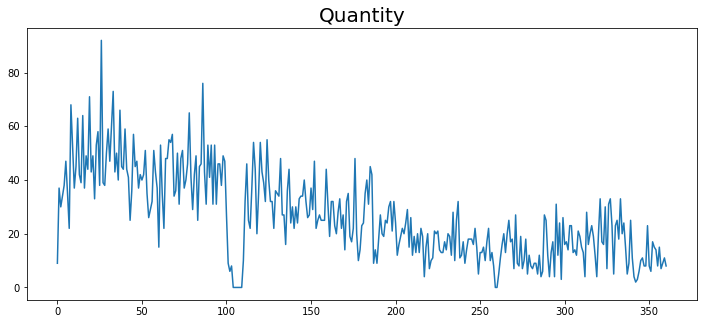

In [33]:
#########################
# Визуализируем quantity.
#########################

plt.figure(figsize=(12,5))
plt.plot(quantity, label='price')
plt.title('Quantity', fontsize=20)
plt.show()

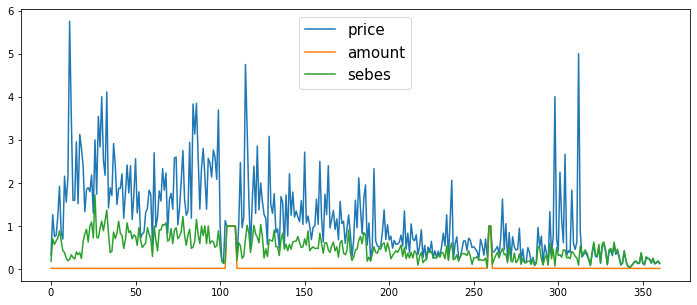

In [34]:
####################################################
# Вывод разницы между quantity и другими атрибутами.
####################################################

dif_qp = (quantity+1) / (price+1)   
dif_qa = (quantity+1) / (amount+1)
dif_qs = (quantity+1) / (sebes+1)

plt.figure(figsize=(12,5))
plt.plot(dif_qp, label='price')
plt.plot(dif_qa, label='amount')
plt.plot(dif_qs, label='sebes')
plt.legend(fontsize=15)
plt.show()

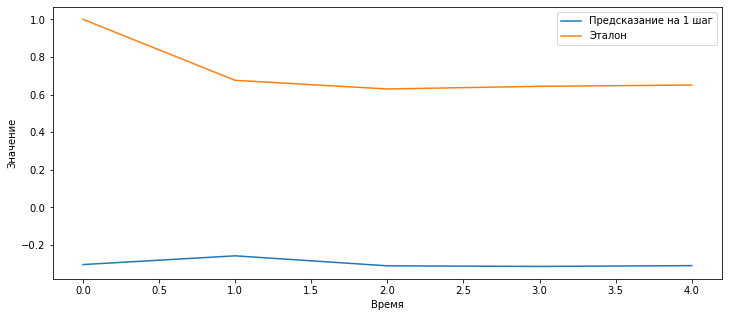

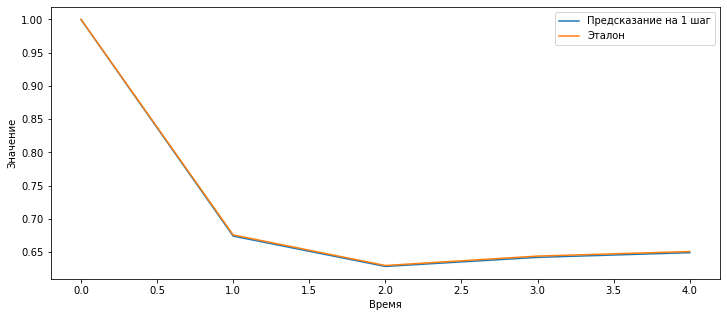

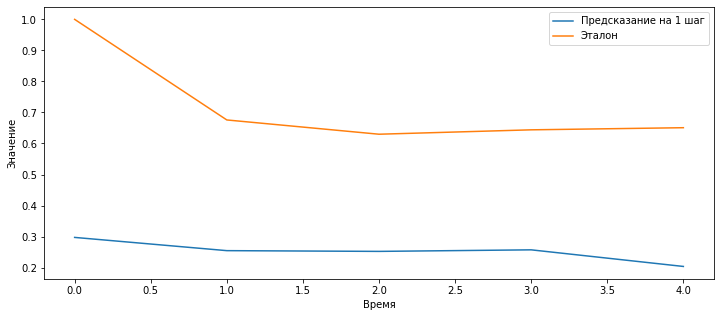

In [35]:
#######################################################
# Вывод корреляции между quantity и другими атрибутами.
#######################################################

for i in [price, amount, sebes]:
    showCorr([0], 5, i, quantity)

### У quantity НЕ наблюдается корреляции с  price и sebes, а с amount корреляция стремиться к 1, т.к. amount = quantity * price. Поэтому не будем учитывать эти атрибуды при прогнозировании.

### Изучение stocks_on_days

In [36]:
query = ''

select_ = 'select count(*) '

from_ = 'from test.stocks_on_days '

where_ = f'''where test.stocks_on_days.item_id == '{product_id}' '''

limit_ = 'limit 200'

query = select_ + from_ + where_

In [37]:
query

"select count(*) from test.stocks_on_days where test.stocks_on_days.item_id == '7d185936-7a60-11eb-ba7f-4a6a34607ded' "

In [38]:
read_sql(query)

,count__
0,4260


In [39]:
query = ''

select_ = 'select date, start_day, finish_day '

from_ = 'from test.stocks_on_days '

product_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded'
where_ = f'''where test.stocks_on_days.item_id == '{product_id}' '''

query = select_ + from_ + where_

In [40]:
data_stocks = read_sql(query)

In [41]:
data_stocks.index = pd.to_datetime(data_stocks.date, dayfirst=True)
data_stocks.drop('date', axis=1, inplace=True)
data_stocks

,start_day,finish_day
date,,
2020-08-26,0,0
2020-08-27,0,0
2020-08-28,0,0
2020-08-29,0,0
2020-08-30,0,0
...,...,...
2022-01-09,5,5
2022-01-09,-2,-2
2022-01-09,-2,-2


In [42]:
funcs = dict(start_day='sum', finish_day ='sum') 
stocks_data_sum = data_stocks.resample('D').agg(funcs).dropna()
stocks_data_sum

,start_day,finish_day
date,,
2020-08-26,0,0
2020-08-27,0,0
2020-08-28,0,0
2020-08-29,0,0
2020-08-30,0,0
...,...,...
2022-01-05,40,40
2022-01-06,40,40
2022-01-07,40,40


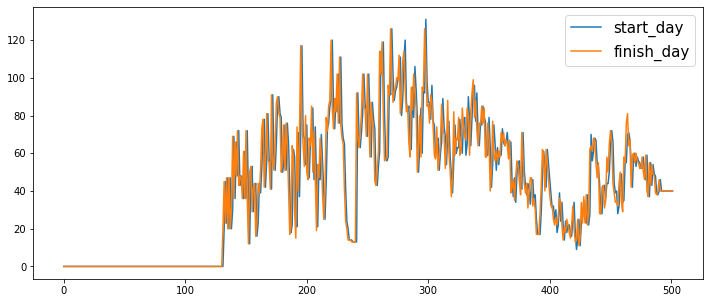

In [43]:
####################################
# Отображаем start_day и finish_day.
####################################

'''
start_day - количество остатков товаров на начало дня
finish_day - количество остатков товаров на конец дня

'''

plt.figure(figsize=(12,5))
plt.plot(stocks_data_sum.start_day.values, label='start_day')
plt.plot(stocks_data_sum.finish_day.values, label='finish_day')
plt.legend(fontsize=15)
plt.show()

### Обрежем значения до интервала 2021-01-04 -- 2021-12-30 (т.е. интервала равного длине ряда quantity)

In [44]:
stocks_data_sum.shape

(502, 2)

In [45]:
stocks_data_sum_cut = stocks_data_sum.iloc[(stocks_data_sum.index <= '2021-12-30') & (stocks_data_sum.index >= '2021-01-04')]

In [46]:
stocks_data_sum_cut

,start_day,finish_day
date,,
2021-01-04,0,20
2021-01-05,20,45
2021-01-06,45,23
2021-01-07,23,47
2021-01-08,47,20
...,...,...
2021-12-26,48,39
2021-12-27,39,38
2021-12-28,38,40


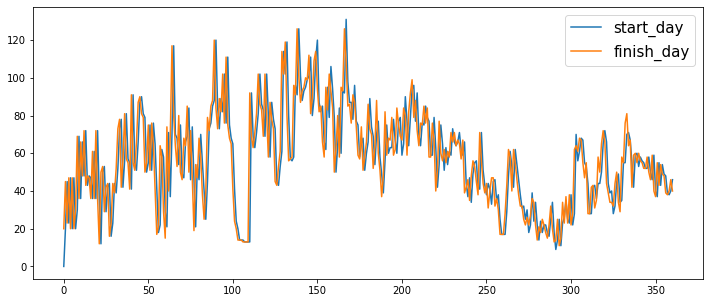

In [47]:
#############################
# Отображаем обрезанные ряды.
#############################

plt.figure(figsize=(12,5))
plt.plot(stocks_data_sum_cut.start_day.values, label='start_day')
plt.plot(stocks_data_sum_cut.finish_day.values, label='finish_day')
plt.legend(fontsize=15)
plt.show()

In [48]:
start_day = stocks_data_sum_cut.start_day.values + 1
finish_day = stocks_data_sum_cut.finish_day.values

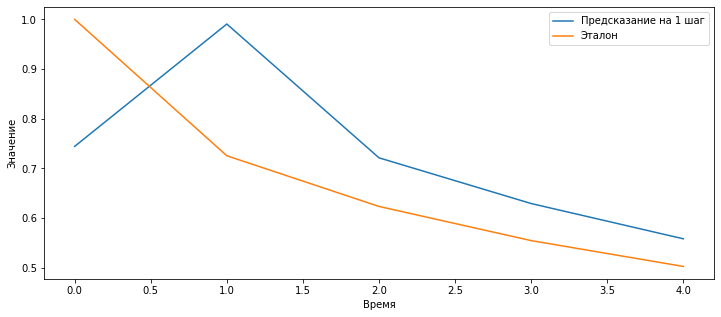

In [49]:
################################################
# Вывод корреляции между start_day и finish_day.
################################################

showCorr([0], 5, start_day, finish_day)

### Ряды одинаковы и просто сдвинуты во времени

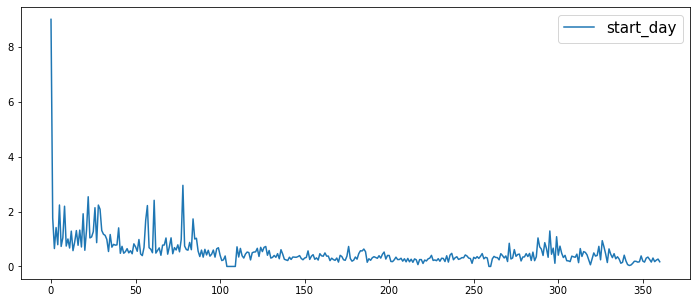

In [50]:
###########################################
# Вывод разницы между start_day и quantity.
###########################################

dif_qsd = quantity / start_day

plt.figure(figsize=(12,5))
plt.plot(dif_qsd, label='start_day')
plt.legend(fontsize=15)
plt.show()

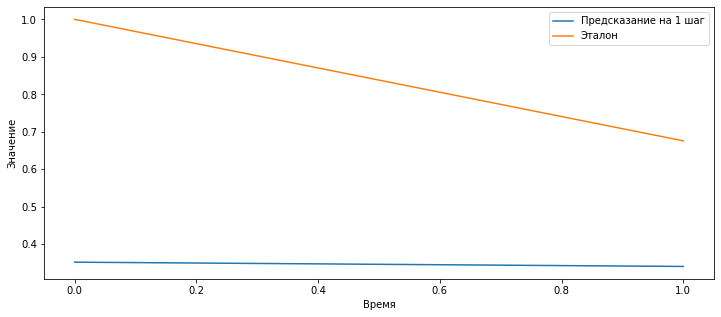

In [51]:
##############################################
# Вывод корреляции между start_day и quantity.
##############################################

showCorr([0], 2, start_day, quantity)

### Корреляция между рядами очень низкая и не изменяется при сдвиге. Данный атрибут так же не будем учитывать при обучении модели.

##  Анализ посредством сглаживания

In [52]:
all_sum

,price,quantity,amount,sebes
date,,,,
2021-01-04,29.995000,9,539.91,53.5
2021-01-05,29.027419,37,2217.95,53.5
2021-01-06,40.793200,30,1799.70,53.5
2021-01-07,44.992500,34,2038.86,53.5
2021-01-08,31.869688,38,2278.91,53.5
...,...,...,...,...
2021-12-26,65.650000,15,981.33,62.0
2021-12-27,65.104286,7,455.31,62.0
2021-12-28,69.204286,9,602.64,62.0


In [53]:
##################################################################################
# Функция для расчета и отображения ряда после прохода по нему скользящим средним.
##################################################################################

def plotMovingAverage(series, n):
       
    '''
    Input:
        series - dataframe with timeseries
        n - rolling window size (размер скользящего окна)
    '''      

    rolling_mean = series.rolling(window=n).mean()

    plt.figure(figsize=(12,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    plt.plot(series, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

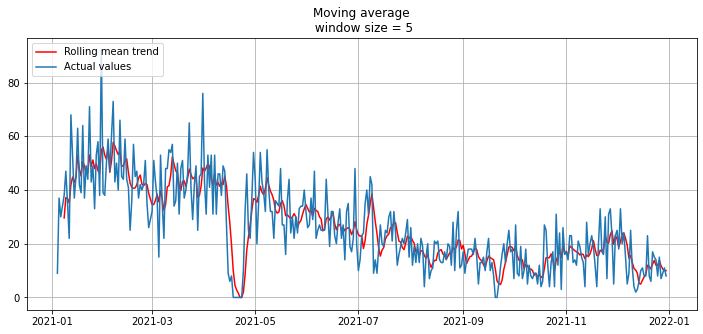

In [54]:
#################################
# Сглаживание скользящим средним.
#################################

plotMovingAverage(all_sum.quantity, 5)

In [55]:
#######################################################################################
# Функция для расчета и отображения ряда после обработки экспоненциальным сглаживанием.
#######################################################################################

def exponential_smoothing(series, alpha):
    
    '''
    Input:
        series - dataframe with timeseries
        alpha - сглаживающим фактор (чем он меньше, тем больше влияния оказывают предыдущие модельные значения -> сильнее сглаживается ряд) 
    Output:
        result - сглаженный ряд
    '''        
    
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

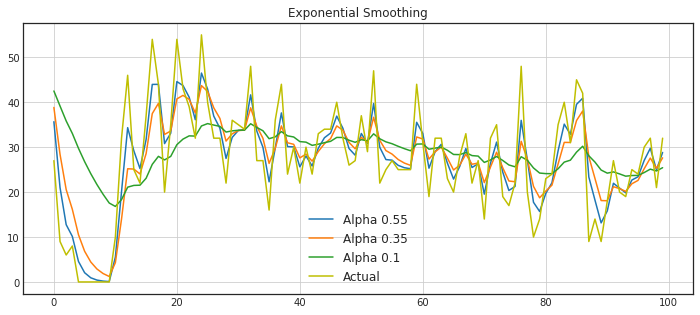

In [56]:
################################################
# Экспоненциальное сглаживание при разных alpha.
################################################

with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(12, 5))
    for alpha in [0.55, 0.35, 0.1]:
        plt.plot(exponential_smoothing(quantity, alpha)[100:200], label="Alpha {}".format(alpha))
    plt.plot(quantity[100:200], "y", label = "Actual")
    plt.legend(loc="best", fontsize=12)
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

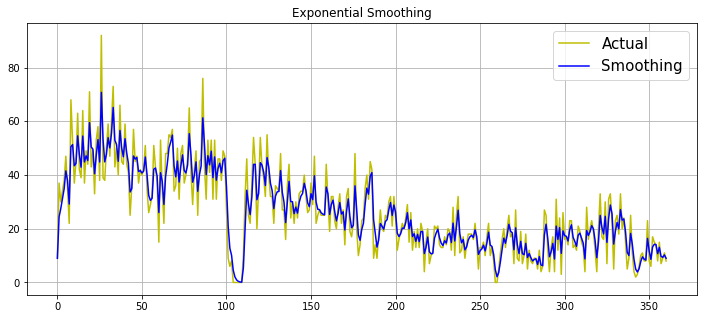

In [57]:
#############################################
# Исходный ряд и сглаженный при alpha = 0.55.
#############################################

quantity_smooth = exponential_smoothing(quantity, alpha = 0.55)

plt.figure(figsize=(12, 5))
plt.plot(quantity, "y", label = "Actual")
plt.plot(quantity_smooth, "b", label = "Smoothing")
plt.legend(loc="best", fontsize=15)
plt.axis('tight')
plt.title("Exponential Smoothing")
plt.grid(True)

In [58]:
quantity.mean()

26.545706371191137

# Forecasting

## LinearRegression

### Training on non-smoothed data

In [147]:
all_sum.head()

,price,quantity,amount,sebes
date,,,,
2021-01-04,29.995000,9,539.91,53.5
2021-01-05,29.027419,37,2217.95,53.5
2021-01-06,40.793200,30,1799.70,53.5
2021-01-07,44.992500,34,2038.86,53.5
2021-01-08,31.869688,38,2278.91,53.5


In [148]:
data_quantity = all_sum.drop(['price', 'amount', 'sebes'], axis=1)
data_quantity.head()

,quantity
date,
2021-01-04,9
2021-01-05,37
2021-01-06,30
2021-01-07,34
2021-01-08,38


In [149]:
# Избавимся от Decimal
print(type(data_quantity.quantity.values[0]))
print(type(quantity[0]))

data_quantity['quantity'] = quantity
print(type(data_quantity.quantity.values[0]))
data_quantity.head()

<class 'decimal.Decimal'>
<class 'numpy.int32'>
<class 'numpy.int32'>


,quantity
date,
2021-01-04,9
2021-01-05,37
2021-01-06,30
2021-01-07,34
2021-01-08,38


In [159]:
#############################################
# Функция возврата сгруппированного массива.
#############################################

def code_mean(data, cat_feature, real_feature):

    '''
    Input:
        data - датафрейм для групировки
        cat_feature - элемент по которому группируем
        real_feature - столбец по которому группируем
    Output:
        result - сгруппированный датафрейм
    '''     
    
    return data.groupby(cat_feature)[real_feature].mean()

In [160]:
###################################################
# Функция создания обучающей и проверочной выборок.
###################################################

def prepareData(data, data_orig, lag_start, lag_end, test_size):

    '''
    Input:
        data - датафрейм
        data_orig - датафрейм без предобработок (сглаживания)
        lag_start - лаг начала предсказания (в нашем случае 7, т.к. предсказываем на 7 дней)
        lag_end - лаг определяющий окончание сдвига в данных. lag_end-lag_end - это длина одного нашего примера
        test_size - доля проверочной выборки
    Output:
        X_train, X_test, y_train, y_test, y_test_orig - данные для обучения и проверки модели   

    '''    
    
    data = data.copy()
    data_orig = data_orig.copy()
    
    data.columns = ['y']
    data_orig.columns = ['y']

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = data.y.shift(i)
        data_orig[f'lag_{i}'] = data_orig.y.shift(i)
        
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1   
 
    data['av_week'] = data['weekday'].map(code_mean(data[:test_index], 'weekday', 'y'))
    data.drop(["weekday"], axis=1, inplace=True)

    
    data = data.dropna()
    data = data.reset_index(drop=True)
    data_orig = data_orig.dropna()
    data_orig = data_orig.reset_index(drop=True) 
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:test_index].drop(["y"], axis=1)
    y_train = data.iloc[:test_index]["y"]
    X_test = data.iloc[test_index:].drop(["y"], axis=1)
    y_test = data.iloc[test_index:]["y"]

    y_test_orig = data_orig.iloc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test, y_test_orig

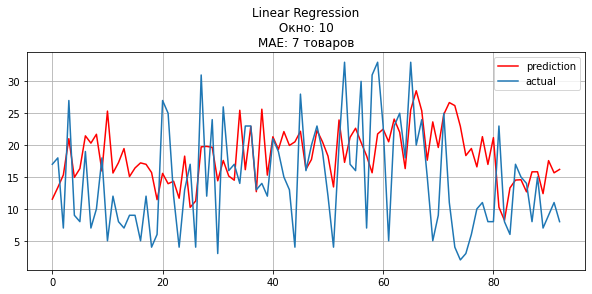

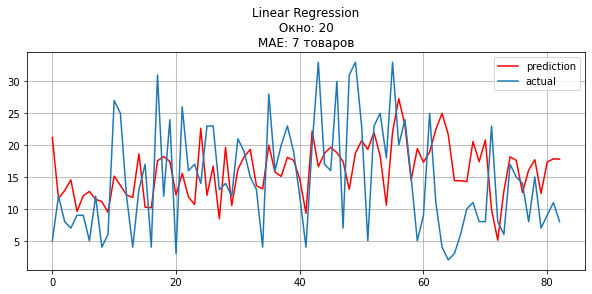

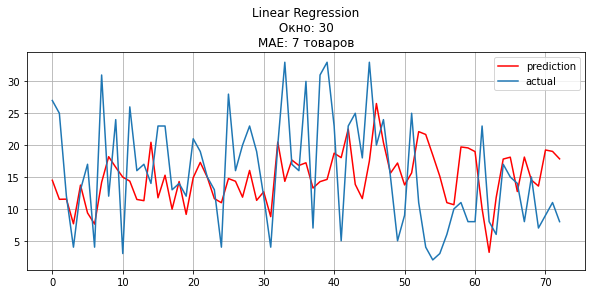

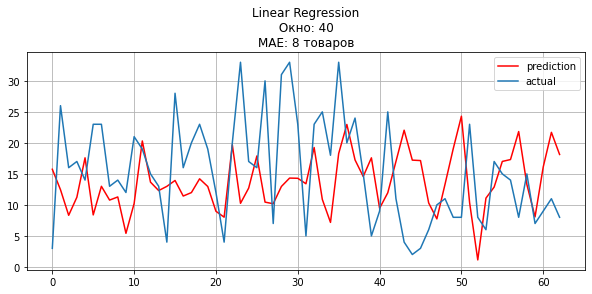

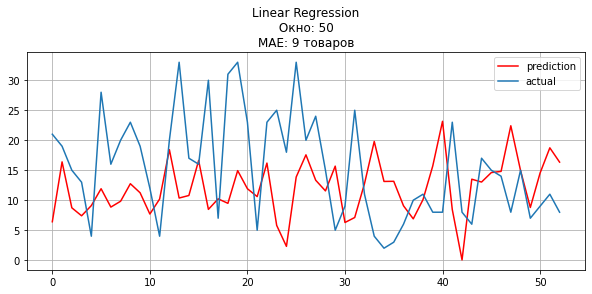

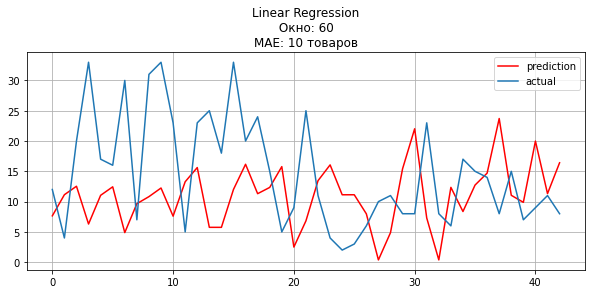

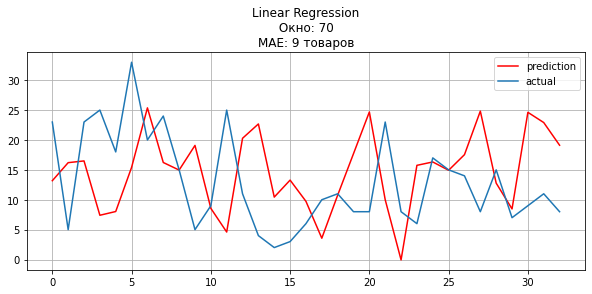

In [161]:
###################################################################################
# Проверка точности в зависимости от длины окна, по которому делается предсказание.
###################################################################################

for window in [10, 20, 30, 40, 50, 60, 70]:

    x_train, x_test, y_train, y_test, y_test_orig = prepareData(data_quantity, data_quantity, test_size=0.3, lag_start=7, lag_end=7+window)

    lr = LinearRegression(normalize=True)
    lr.fit(x_train, y_train)

    prediction = lr.predict(x_test)
    plt.figure(figsize=(10, 4))
    plt.plot(prediction, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title(f"Linear Regression\n Окно: {window} \nMAE: {round(mean_absolute_error(prediction, y_test))} товаров")
    plt.grid(True)

### Training on smoothed data

In [94]:
data_quantity

,quantity
date,
2021-01-04,9
2021-01-05,37
2021-01-06,30
2021-01-07,34
2021-01-08,38
...,...
2021-12-26,15
2021-12-27,7
2021-12-28,9


In [95]:
quantity_smooth[:10]

[9,
 24.400000000000002,
 27.48,
 31.066000000000003,
 34.8797,
 41.545865,
 37.94563925,
 29.1755376625,
 50.528991948125004,
 51.33804637665625]

In [96]:
data_quantity_smooth = data_quantity.copy()
data_quantity_smooth['quantity'] = quantity_smooth

# Избавимся от Decimal
print(type(data_quantity_smooth.quantity.values[0]))
print(type(quantity_smooth[0]))

data_quantity_smooth['quantity'] = quantity_smooth
print(type(data_quantity_smooth.quantity.values[0]))
data_quantity_smooth.head()

<class 'numpy.float64'>
<class 'numpy.int32'>
<class 'numpy.float64'>


,quantity
date,
2021-01-04,9.0000
2021-01-05,24.4000
2021-01-06,27.4800
2021-01-07,31.0660
2021-01-08,34.8797


### подсчёт МАЕ будем производить по оригинальной (НЕ сглаженной) выборке

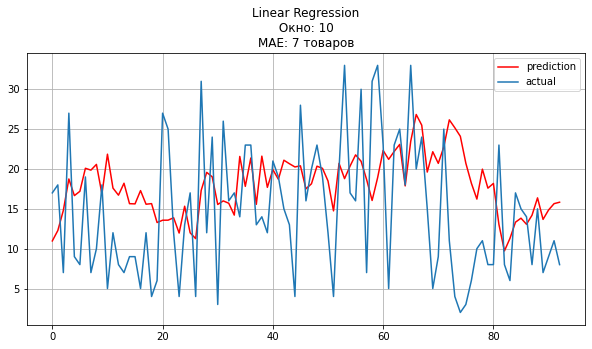

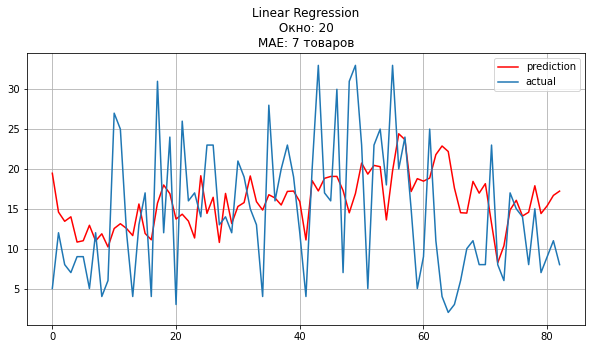

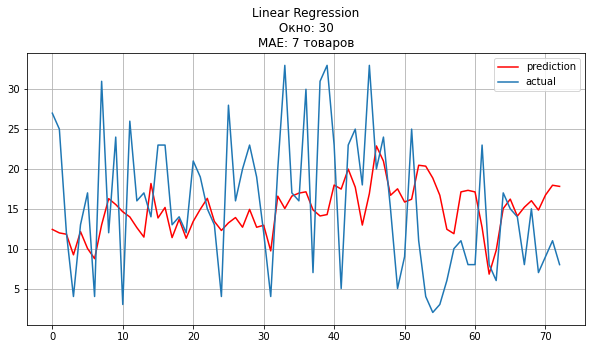

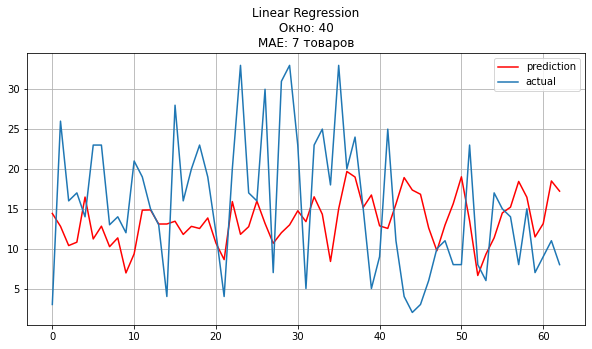

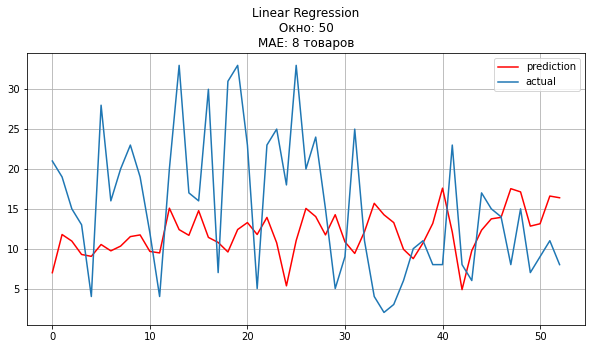

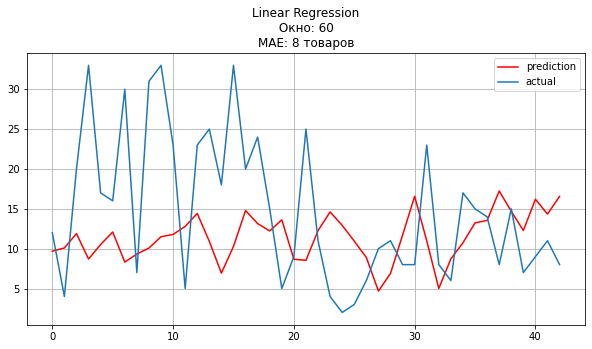

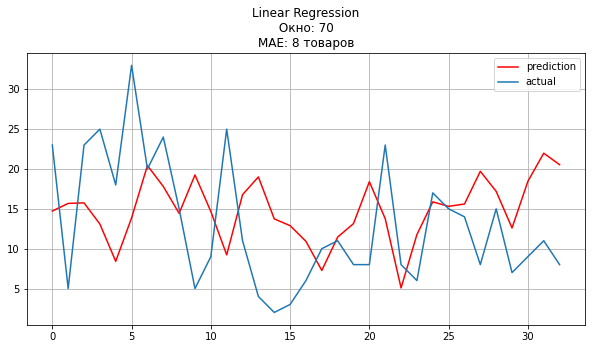

In [97]:
###################################################################################
# Проверка точности в зависимости от длины окна, по которому делается предсказание.
###################################################################################

for window in [10, 20, 30, 40, 50, 60, 70]:

    x_train, x_test, y_train, y_test, y_test_origin = prepareData(data_quantity_smooth, data_quantity, test_size=0.3, lag_start=7, lag_end=7+window)

    lr = LinearRegression(normalize=True)
    lr.fit(x_train, y_train)

    prediction = lr.predict(x_test)
    plt.figure(figsize=(10, 5))
    plt.plot(prediction, "r", label="prediction")
    plt.plot(y_test_origin.values, label="actual")
    plt.legend(loc="best")
    plt.title(f"Linear Regression\n Окно: {window} \nMAE: {round(mean_absolute_error(prediction, y_test_origin))} товаров")
    plt.grid(True)

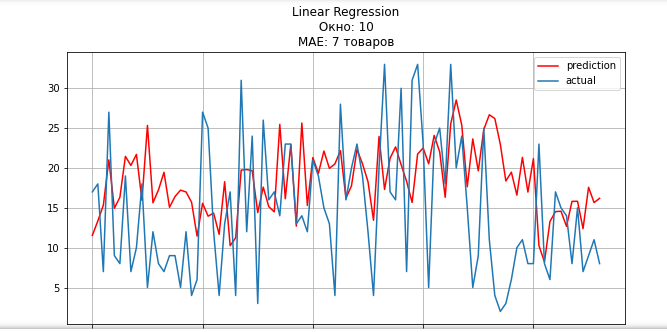

**Ошибка осталась на таком же уровне, но предсказание стало более стабильным и плавным**

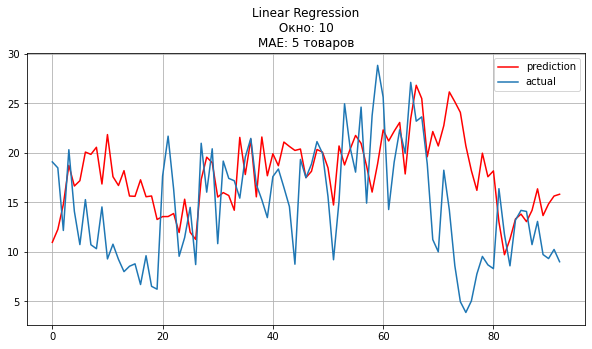

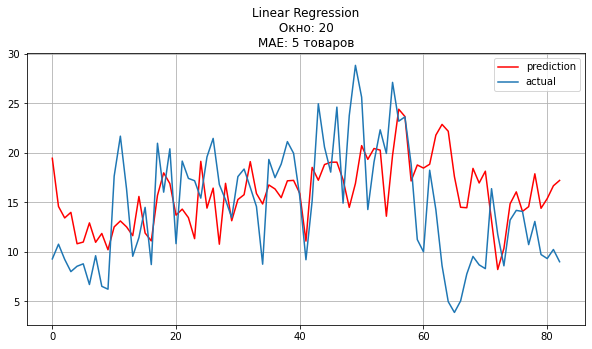

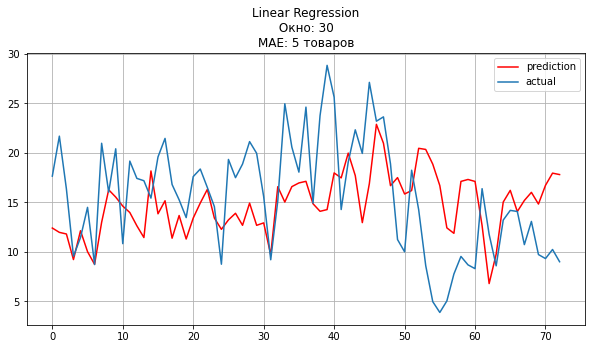

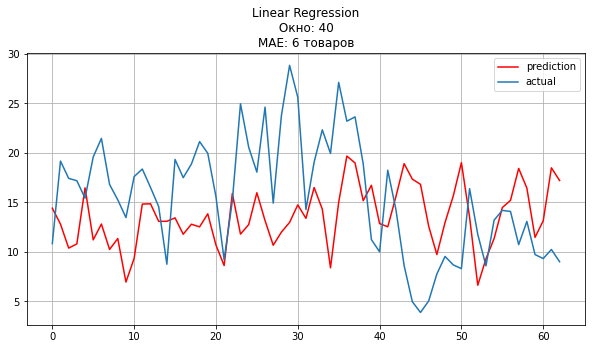

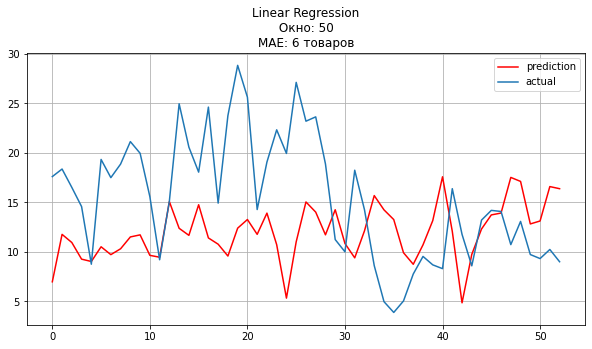

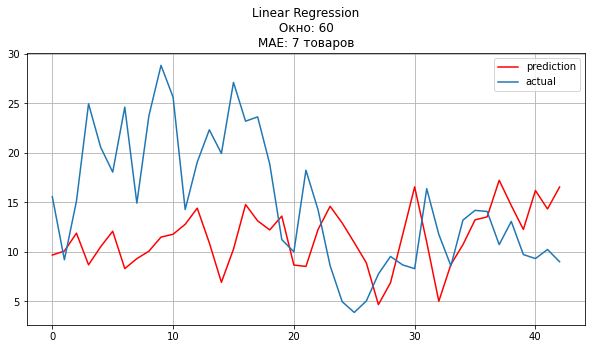

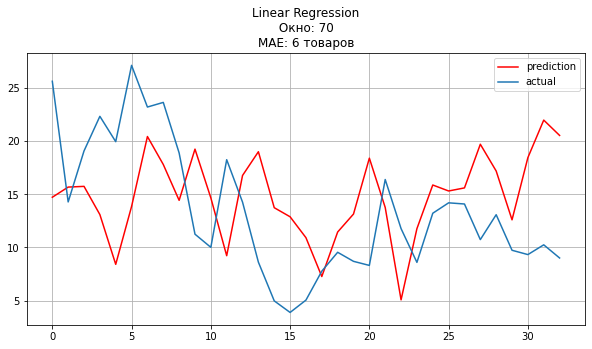

In [98]:
###################################################################################
# Проверка точности в зависимости от длины окна, по которому делается предсказание.
###################################################################################

for window in [10, 20, 30, 40, 50, 60, 70]:

    x_train, x_test, y_train, y_test, y_test_origin = prepareData(data_quantity_smooth, data_quantity, test_size=0.3, lag_start=7, lag_end=7+window)

    lr = LinearRegression(normalize=True)
    lr.fit(x_train, y_train)

    prediction = lr.predict(x_test)
    plt.figure(figsize=(10, 5))
    plt.plot(prediction, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title(f"Linear Regression\n Окно: {window} \nMAE: {round(mean_absolute_error(prediction, y_test))} товаров")
    plt.grid(True)

**Если же сравнивать предсказания с сглаженным рядом, то MAE уже 5 товаров**

## Dense

**Подготовим функции для анализа результатов**

In [530]:
######################################
#  Функция получения метрик и ошибки.
######################################

def show_losses(history):

    '''
    Input:
        history - история текущей модели

    '''    
    
    # графики обучения
    acc = history.history['log_cosh']
    val_acc = history.history['val_log_cosh']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [531]:
################################
# Функция визуализации графиков.
################################

def showPredict(start, step, channel, predVal, yValUnscaled):

    '''
    Input:
        start - точка с которой начинаем отрисовку графика
        step - длина графика, которую отрисовываем
        channel - какой канал отрисовываем  
        predVal - предсказанные моделью значения
        yValUnscaled - истинные значения
        
    '''    
    
    plt.figure(figsize=(22,6))
    plt.plot(predVal[start:start+step],#, 0],
             label='Прогноз')
    plt.plot(yValUnscaled[start:start+step],#, channel], 
             label='Базовый ряд')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.title(f"MAE: {round(mean_absolute_error(predVal, yValUnscaled))} товаров", fontsize=20)
    plt.legend()
    plt.show()

In [532]:
############################################
# Функция отображения необходимых графиков.
############################################


def get_inf(model, window, steps, Scaler, x_test, y_test):
       
    '''
    Input:
        model - текущая модель
        window - кол-во значений на графике предсказанного временного ряда
        steps - кол-во сдвигов подсчета автокорелляции 
        Scaler - нормализатор
        x_test - тестовая выборка
        y_test - таргеты по тестовой выборке
    '''
    
    show_losses(history)
    
    predictions = model.predict(x_test, verbose=1)
    pred = Scaler.inverse_transform(predictions)
    y_un = Scaler.inverse_transform(y_test.reshape(-1,1))
        
    showPredict(0,window,0,pred,y_un)
    
    pred = predictions.reshape(predictions.shape[0])
    showCorr([0], steps, pred, y_test)
    
    

In [533]:
data_quantity.head()

,quantity
date,
2021-01-04,9
2021-01-05,37
2021-01-06,30
2021-01-07,34
2021-01-08,38


In [534]:
test = data_quantity.copy()

In [535]:
test.iloc[:2] = np.array([[1],[2]])

In [536]:
test

,quantity
date,
2021-01-04,1
2021-01-05,2
2021-01-06,30
2021-01-07,34
2021-01-08,38
...,...
2021-12-26,15
2021-12-27,7
2021-12-28,9


In [537]:
#####################################################################################################
# Функция подготовки данных для Dense (данные частично несвязаны, т.к. присутствуют Dummy параметры).
#####################################################################################################

'''
Отличается от предыдущей prepareData наличием блока нормализации
'''


def prepareData(data, lag_start, lag_end, test_size):

    data = data.copy()   
    data.columns = ['y']

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # Производим нормализацию. Scaler обучаем только на обучающих данных, т.к. это неизвестные данные для модели.
    Scaler = StandardScaler()
    normal_train = Scaler.fit_transform(data.iloc[:test_index].values.reshape(-1,1)) # fit_transform!
    normal_test = Scaler.transform(data.iloc[test_index:].values.reshape(-1,1))      # просто transform!
    data.iloc[:test_index] = normal_train
    data.iloc[test_index:] = normal_test
    
    # формирование Dummy параметров
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1   
 
    data['av_week'] = data['weekday'].map(code_mean(data[:test_index], 'weekday', 'y'))
    data.drop(["weekday"], axis=1, inplace=True)
    
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = data.y.shift(i)
   
    # Избавляемся от NaN и сбрасываем индексный столбец до простых range индексов
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:test_index].drop(["y"], axis=1)
    y_train = data.iloc[:test_index]["y"]
    X_test = data.iloc[test_index:].drop(["y"], axis=1)
    y_test = data.iloc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test, Scaler

In [538]:
x_train, x_test, y_train, y_test, Scaler = prepareData(data_quantity, test_size=0.3, lag_start=7, lag_end=7+10)

In [539]:
x_train.head()

,is_weekend,av_week,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16
0,0,-0.017234,1.269575,2.276643,-0.618677,0.199565,0.954866,0.388390,0.136624,-0.115143,0.325449,-1.436920
1,0,0.008992,0.325449,1.269575,2.276643,-0.618677,0.199565,0.954866,0.388390,0.136624,-0.115143,0.325449
2,0,-0.088918,0.828983,0.325449,1.269575,2.276643,-0.618677,0.199565,0.954866,0.388390,0.136624,-0.115143
3,1,0.286984,1.961934,0.828983,0.325449,1.269575,2.276643,-0.618677,0.199565,0.954866,0.388390,0.136624
4,1,-0.151859,0.640157,1.961934,0.828983,0.325449,1.269575,2.276643,-0.618677,0.199565,0.954866,0.388390


In [540]:
x_train.shape

(252, 12)

In [541]:

input_shape = x_train.shape[1:]

##########################
# Функция создания модели.
##########################

def create_model():
    model = Sequential()                                   
    model.add(Dense(units=64, activation='linear', input_shape = input_shape)) 
    model.add(Dropout(0.2))    
    model.add(Dense(64, activation='linear'))                 
    model.add(Dropout(0.15))  
    model.add(Dense(7, activation='linear'))     
    model.add(Dense(1, activation='linear'))               

    #Компилируем сеть
    model.compile(loss="mean_absolute_error", optimizer=Adam(learning_rate=0.0001), metrics=["log_cosh"])

    return model



In [156]:
model_D1 = create_model()

In [542]:
#################
# гиперпараметры
#################

batch_size = 5 
epochs = 50

# обучение модели
history = model_D1.fit(
        x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
        validation_data=(x_test, y_test)

)

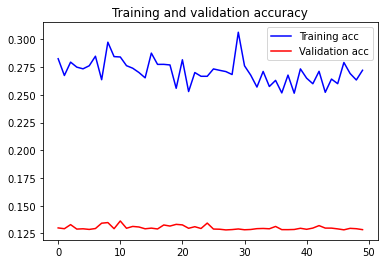

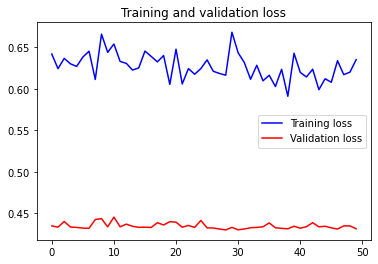

3/3 [==============================] - 0s 4ms/step


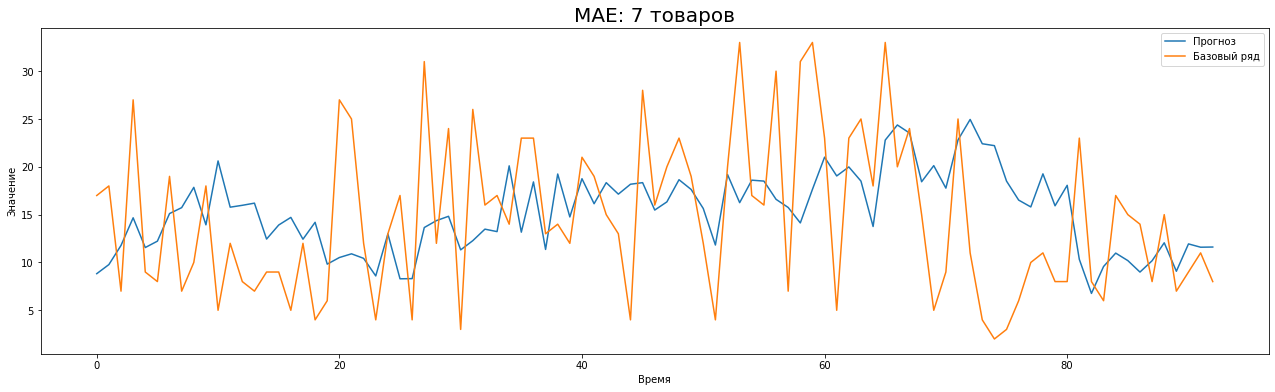

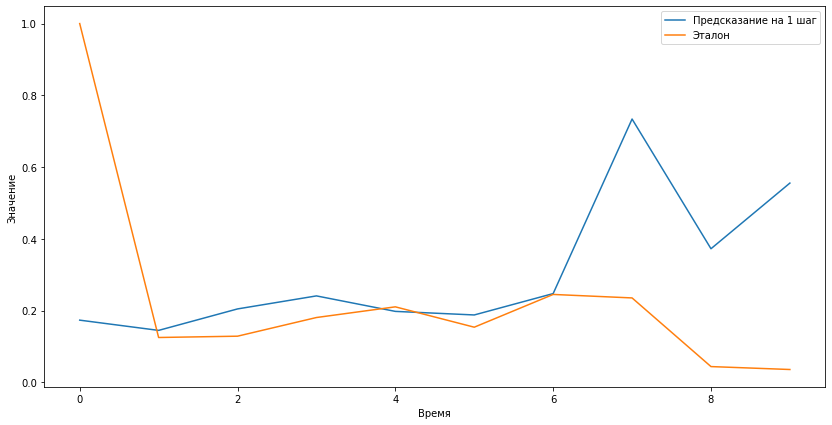

In [543]:
get_inf(model_D1, 200, 10, Scaler, x_test.values, y_test.values)

# С использованием фич из библиотеки tsfresh

In [544]:
#####################################################################################################
# Функция подготовки данных для Dense (данные частично несвязаны, т.к. присутствуют Dummy параметры).
#####################################################################################################

'''
Отличается от предыдущей prepareData тем, что убраны Dummy параметры
'''

def prepareData(data, lag_start, lag_end, test_size):

    data = data.copy()   
    data.columns = ['y']

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # Производим нормализацию. Scaler обучаем только на обучающих данных, т.к. это неизвестные данные для модели.
    Scaler = MinMaxScaler()
    normal_train = Scaler.fit_transform(data.iloc[:test_index].values.reshape(-1,1)) # fit_transform!
    normal_test = Scaler.transform(data.iloc[test_index:].values.reshape(-1,1))      # просто transform!
    data.iloc[:test_index] = normal_train
    data.iloc[test_index:] = normal_test
    
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = data.y.shift(i)
   
    # Избавляемся от NaN и сбрасываем индексный столбец до простых range индексов
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:test_index].drop(["y"], axis=1)
    y_train = data.iloc[:test_index]["y"]
    X_test = data.iloc[test_index:].drop(["y"], axis=1)
    y_test = data.iloc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test, Scaler

In [545]:
x_train, x_test, y_train, y_test, Scaler = prepareData(data_quantity, test_size=0.3, lag_start=7, lag_end=7+10)

In [546]:
x_train

,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16
0,0.565217,0.739130,0.239130,0.380435,0.510870,0.413043,0.369565,0.326087,0.402174,0.097826
1,0.402174,0.565217,0.739130,0.239130,0.380435,0.510870,0.413043,0.369565,0.326087,0.402174
2,0.489130,0.402174,0.565217,0.739130,0.239130,0.380435,0.510870,0.413043,0.369565,0.326087
3,0.684783,0.489130,0.402174,0.565217,0.739130,0.239130,0.380435,0.510870,0.413043,0.369565
4,0.456522,0.684783,0.489130,0.402174,0.565217,0.739130,0.239130,0.380435,0.510870,0.413043
...,...,...,...,...,...,...,...,...,...,...
247,0.108696,0.239130,0.184783,0.108696,0.163043,0.141304,0.141304,0.054348,0.163043,0.239130
248,0.141304,0.108696,0.239130,0.184783,0.108696,0.163043,0.141304,0.141304,0.054348,0.163043
249,0.086957,0.141304,0.108696,0.239130,0.184783,0.108696,0.163043,0.141304,0.141304,0.054348
250,0.000000,0.086957,0.141304,0.108696,0.239130,0.184783,0.108696,0.163043,0.141304,0.141304


In [547]:
#########################################
# Функция получения features датафреймов. 
#########################################

def get_series_features(data):

    '''
    Input:
        data - датафрейм   
    Output:
        data - features датафрейм    
    '''    
    
    data_re = data.reshape(data.shape[0]*data.shape[1])
    
    index_list = []

    for row_ind in range(data.shape[0]):
        index_list.append(np.full(data.shape[1], row_ind))

    all_indexes = np.array(index_list).reshape(data.shape[0]*data.shape[1])

    data = pd.DataFrame({'column_id':all_indexes, 'column_v':data_re})
  
    fc_parameters = {
    'variance_larger_than_standard_deviation':None,
    'has_duplicate_max':None,
    'has_duplicate_min':None,
    'has_duplicate':None,
    'sum_values':None,   
    'mean_abs_change':None,
    'mean_change':None,
    'mean_second_derivative_central':None,
    'median':None,
    'mean':None,
    'standard_deviation':None,
    'variation_coefficient':None,
    'variance':None,
    'root_mean_square':None,
    'absolute_sum_of_changes':None,
    'longest_strike_below_mean':None,
    'longest_strike_above_mean':None,
    'count_above_mean':None,
    'count_below_mean':None,
    'last_location_of_maximum':None,
    'first_location_of_maximum':None
    }

    data = extract_features(data, column_id='column_id', column_sort=None,
                         default_fc_parameters=fc_parameters,
                         # we impute = remove all NaN features automatically
                         impute_function=impute)
    return data

In [548]:
x_train_f = get_series_features(x_train.values)
x_test_f = get_series_features(x_test.values)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.98it/s]


In [443]:
x_train_f.head()

,column_v__variance_larger_than_standard_deviation,column_v__has_duplicate_max,column_v__has_duplicate_min,column_v__has_duplicate,column_v__sum_values,column_v__mean_abs_change,column_v__mean_change,column_v__mean_second_derivative_central,column_v__median,column_v__mean,...,column_v__variation_coefficient,column_v__variance,column_v__root_mean_square,column_v__absolute_sum_of_changes,column_v__longest_strike_below_mean,column_v__longest_strike_above_mean,column_v__count_above_mean,column_v__count_below_mean,column_v__last_location_of_maximum,column_v__first_location_of_maximum
0,0.0,0.0,0.0,0.0,4.043478,0.167874,-0.051932,-0.029891,0.391304,0.404348,...,0.412755,0.027854,0.437438,1.510870,4.0,2.0,4.0,6.0,0.2,0.1
1,0.0,0.0,0.0,1.0,4.347826,0.152174,0.000000,-0.005435,0.402174,0.434783,...,0.304549,0.017533,0.454499,1.369565,4.0,2.0,3.0,7.0,0.3,0.2
2,0.0,0.0,0.0,0.0,4.434783,0.153382,-0.018116,0.002717,0.407609,0.443478,...,0.299541,0.017647,0.462947,1.380435,3.0,2.0,4.0,6.0,0.4,0.3
3,0.0,0.0,0.0,0.0,4.793478,0.170290,-0.035024,0.009511,0.451087,0.479348,...,0.300905,0.020805,0.500579,1.532609,2.0,2.0,5.0,5.0,0.5,0.4
4,0.0,0.0,0.0,0.0,4.880435,0.190821,-0.004831,-0.020380,0.472826,0.488043,...,0.286683,0.019576,0.507703,1.717391,2.0,2.0,5.0,5.0,0.6,0.5


In [433]:
x_test_f.head()

,column_v__variance_larger_than_standard_deviation,column_v__has_duplicate_max,column_v__has_duplicate_min,column_v__has_duplicate,column_v__sum_values,column_v__mean_abs_change,column_v__mean_change,column_v__mean_second_derivative_central,column_v__median,column_v__mean,...,column_v__variation_coefficient,column_v__variance,column_v__root_mean_square,column_v__absolute_sum_of_changes,column_v__longest_strike_below_mean,column_v__longest_strike_above_mean,column_v__count_above_mean,column_v__count_below_mean,column_v__last_location_of_maximum,column_v__first_location_of_maximum
0,0.0,0.0,1.0,1.0,2.978261,0.070938,-0.006865,0.007548,0.152174,0.148913,...,0.532447,0.006287,0.168706,1.347826,7.0,4.0,10.0,10.0,0.05,0.00
1,0.0,0.0,1.0,1.0,2.913043,0.078375,0.000572,-0.007548,0.141304,0.145652,...,0.549104,0.006397,0.166166,1.489130,7.0,4.0,9.0,11.0,0.10,0.05
2,0.0,0.0,1.0,1.0,2.891304,0.074943,0.005149,-0.001812,0.141304,0.144565,...,0.557660,0.006499,0.165525,1.423913,7.0,4.0,9.0,11.0,0.15,0.10
3,0.0,0.0,1.0,1.0,2.913043,0.078375,0.001716,0.006944,0.141304,0.145652,...,0.558157,0.006609,0.166804,1.489130,7.0,4.0,9.0,11.0,0.20,0.15
4,0.0,0.0,1.0,1.0,2.750000,0.078375,0.001716,-0.004529,0.130435,0.137500,...,0.579439,0.006348,0.158915,1.489130,5.0,7.0,10.0,10.0,0.25,0.20


In [444]:

input_shape = x_train_f.shape[1:]

##########################
# Функция создания модели.
##########################

def create_model():
    model = Sequential()                                   
    model.add(Dense(units=64, activation='linear', input_shape = input_shape)) 
    model.add(Dropout(0.2))    
    model.add(Dense(64, activation='linear'))                 
    model.add(Dropout(0.15))  
    model.add(Dense(32, activation='linear'))     
    model.add(Dense(1, activation='linear'))               

    #Компилируем сеть
    model.compile(loss="mean_absolute_error", optimizer=Adam(learning_rate=0.0001), metrics=["log_cosh"])

    return model



In [445]:
model_D2 = create_model()

In [549]:
#################
# гиперпараметры
#################

batch_size = 5 
epochs = 50

# обучение модели
history = model_D2.fit(
        x_train_f, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
        validation_data=(x_test_f, y_test)

)

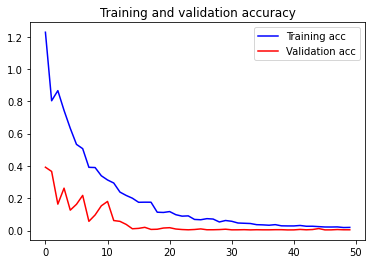

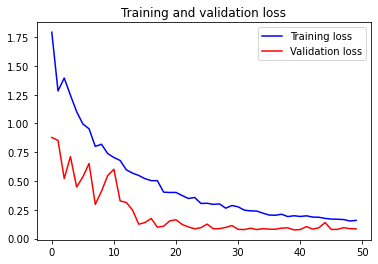

3/3 [==============================] - 0s 2ms/step


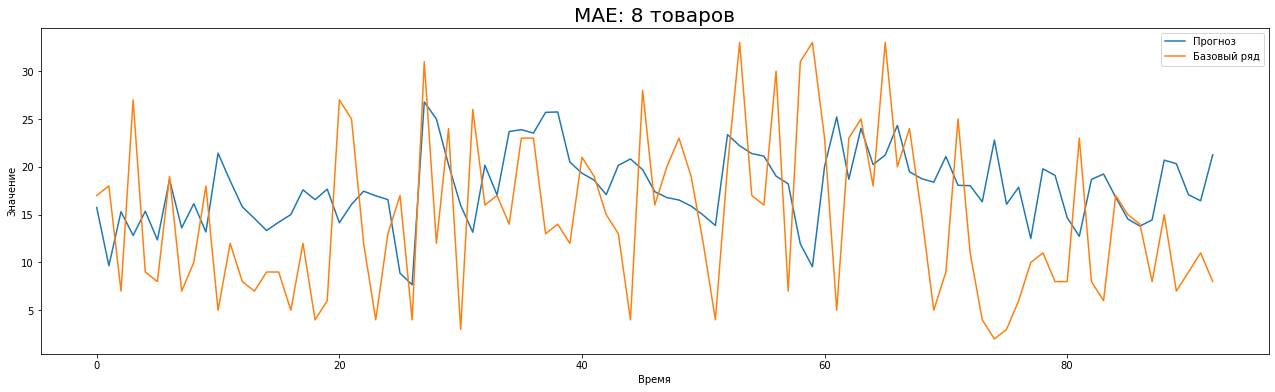

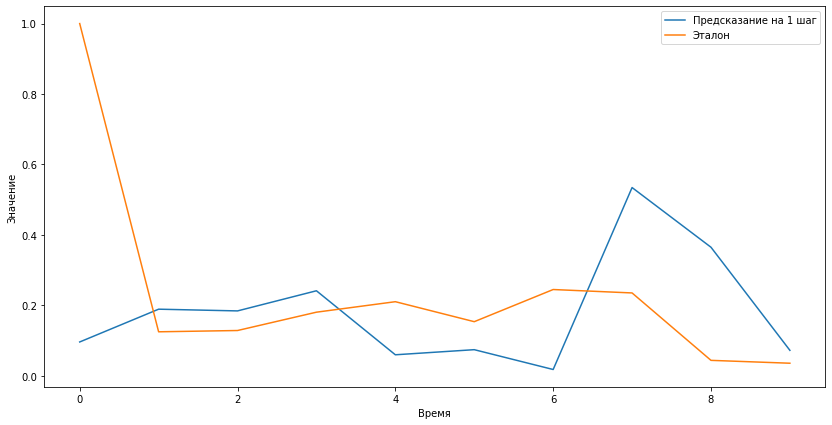

In [447]:
get_inf(model_D2, 200, 10, Scaler, x_test_f.values, y_test.values)

## Conv

In [475]:
##################################################################################
# Функция подготовки данных для Conv (данные связанные, т.к. НЕТ Dummy параметры).
##################################################################################

def prepareData(data, lag_start, lag_end, test_size):

    data = data.copy()   
    data.columns = ['y']

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # Производим нормализацию. Scaler обучаем только на обучающих данных, т.к. это неизвестные данные для модели.
    Scaler = StandardScaler()
    normal_train = Scaler.fit_transform(data.iloc[:test_index].values.reshape(-1,1)) # fit_transform!
    normal_test = Scaler.transform(data.iloc[test_index:].values.reshape(-1,1))      # просто transform!
    data.iloc[:test_index] = normal_train
    data.iloc[test_index:] = normal_test
    
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = data.y.shift(i)
   
    # Избавляемся от NaN и сбрасываем индексный столбец до простых range индексов
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:test_index].drop(["y"], axis=1)
    y_train = data.iloc[:test_index]["y"]
    X_test = data.iloc[test_index:].drop(["y"], axis=1)
    y_test = data.iloc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test, Scaler

In [476]:
data_quantity.head()

,quantity
date,
2021-01-04,9
2021-01-05,37
2021-01-06,30
2021-01-07,34
2021-01-08,38


In [477]:
x_train, x_test, y_train, y_test, Scaler = prepareData(data_quantity, test_size=0.3, lag_start=7, lag_end=7+10)

In [478]:
x_train.shape

(252, 10)

In [479]:
input_shape_conv = (x_train.shape[1], 1)

In [480]:
##########################
# Функция создания модели.
##########################

def conv_model():

    modelC = Sequential()
    modelC.add(Conv1D(64, 5, input_shape = input_shape_conv, activation="tanh"))
    modelC.add(Conv1D(64, 5, activation="tanh"))
    modelC.add(MaxPooling1D())
    modelC.add(Flatten())
    modelC.add(Dense(32, activation="tanh"))
    modelC.add(Dense(1, activation="linear"))

    # компиляция модели

    modelC.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['log_cosh'])

    modelC.summary()
    
    return modelC



In [481]:
model_C1 = conv_model()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 6, 64)             384       
                                                                 
 conv1d_30 (Conv1D)          (None, 2, 64)             20544     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_70 (Dense)            (None, 32)                2080      
                                                                 
 dense_71 (Dense)            (None, 1)                 33        
                                                     

In [482]:
#################
# гиперпараметры
#################

batch_size = 5 
epochs = 50

# обучение модели
history = model_C1.fit(
        x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
        validation_data=(x_test, y_test)

)

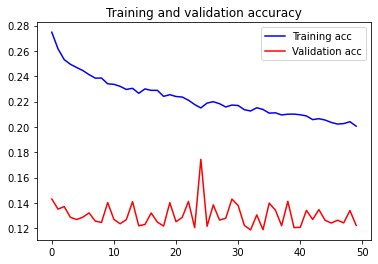

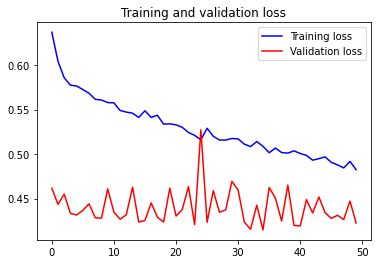

3/3 [==============================] - 0s 2ms/step


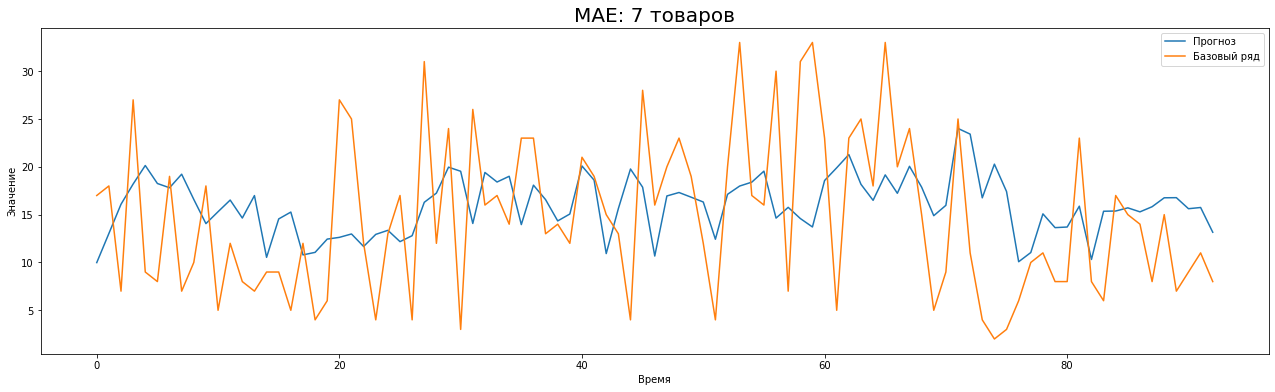

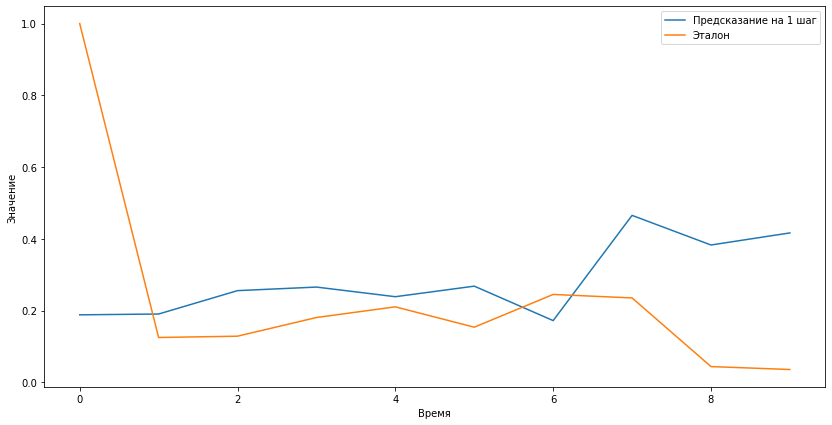

In [483]:
get_inf(model_C1, 200, 10, Scaler, x_test.values, y_test.values)

In [484]:
model_C1.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['log_cosh'])

In [485]:
#################
# гиперпараметры
#################

batch_size = 5 
epochs = 20

# обучение модели
history = model_C1.fit(
        x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
        validation_data=(x_test, y_test)

)

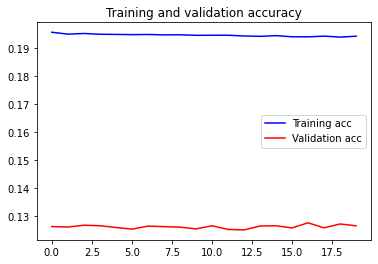

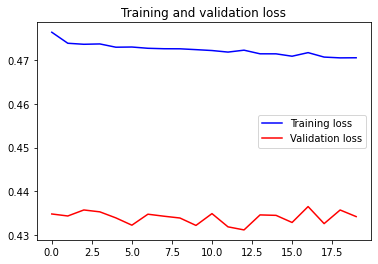

3/3 [==============================] - 0s 3ms/step


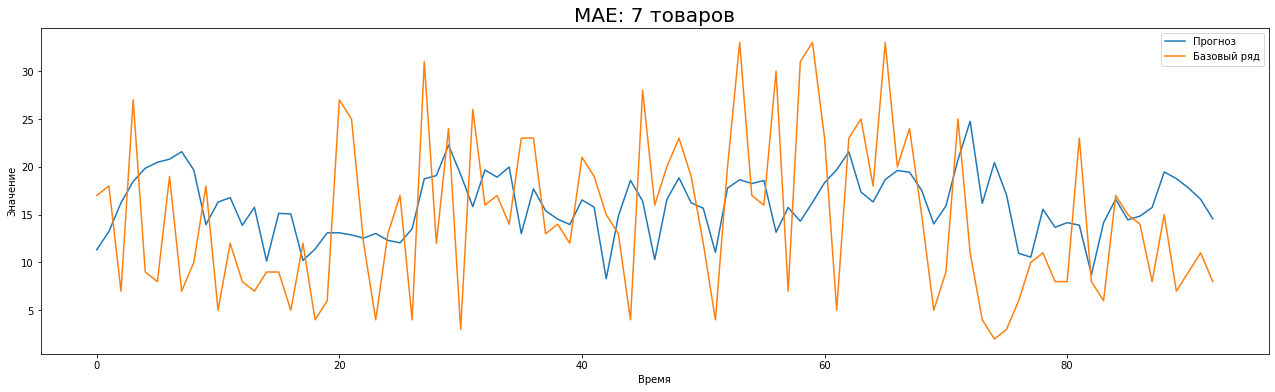

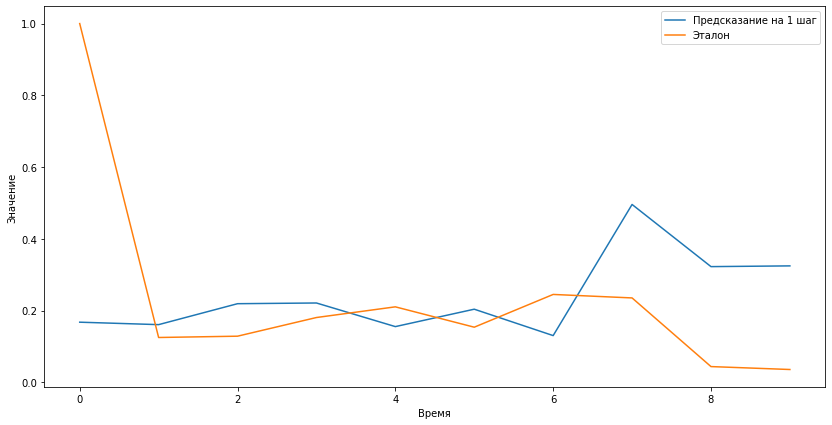

In [205]:
get_inf(model_C1, 200, 10, Scaler, x_test.values, y_test.values)

## Conv + GRU/LSTM

In [145]:
input_shape_conv

(10, 1)

In [222]:
##########################
# Функция создания модели.
##########################

def conv_model():

    modelC = Sequential()
    
#    modelC.add(LSTM(16, input_shape=input_shape_conv))

    modelC.add(Conv1D(64, 5, activation="tanh",input_shape=input_shape_conv, padding='same'))
    
#    modelC.add(LSTM(16, activation='tanh'))
    
    modelC.add(Conv1D(64, 5, activation="tanh", padding='same'))
    modelC.add(MaxPooling1D())
    
    modelC.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, activation="linear"))
    
#    modelC.add(Flatten())
    modelC.add(Dense(64, activation="tanh"))
    modelC.add(Dropout(0.2))  
    modelC.add(Dense(1, activation="linear"))

    # компиляция модели

    modelC.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['log_cosh'])

    modelC.summary()
    
    return modelC



In [232]:
model_C2 = conv_model()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 10, 64)            384       
                                                                 
 conv1d_28 (Conv1D)          (None, 10, 64)            20544     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 5, 64)            0         
 g1D)                                                            
                                                                 
 gru_9 (GRU)                 (None, 32)                9408      
                                                                 
 dense_44 (Dense)            (None, 64)                2112      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                     

In [233]:
#################
# гиперпараметры
#################

batch_size = 5 
epochs = 120

# обучение модели
history = model_C2.fit(
        x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
        validation_data=(x_test, y_test)

)

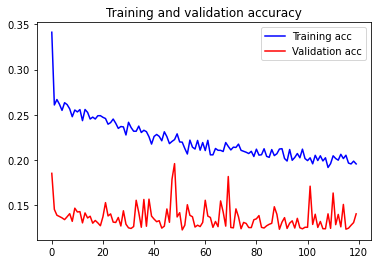

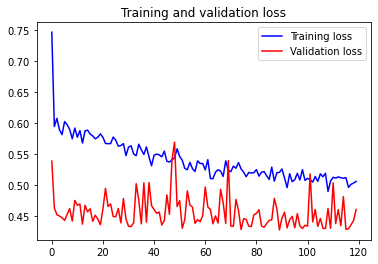

3/3 [==============================] - 0s 4ms/step


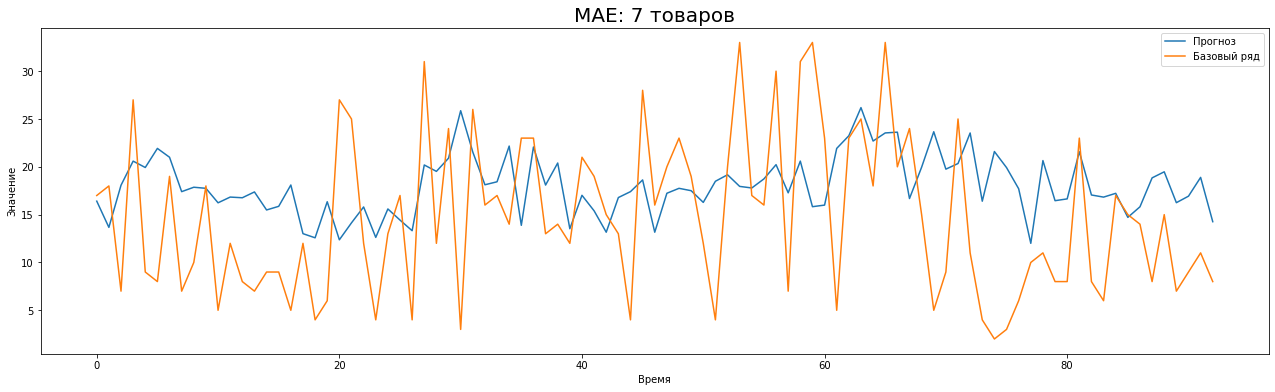

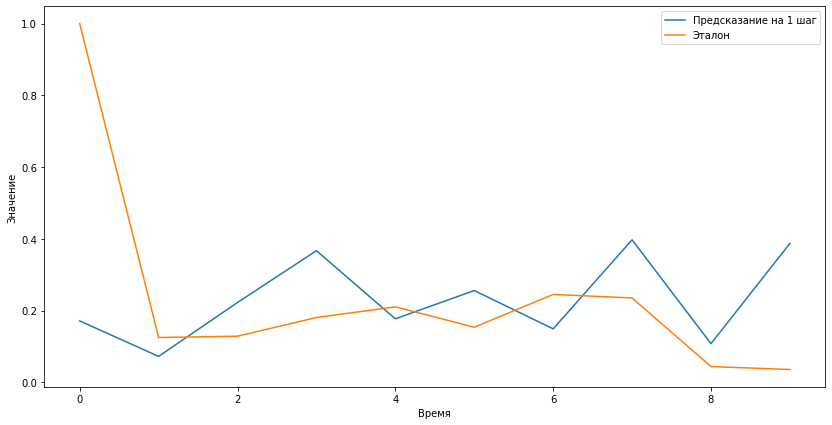

In [234]:
get_inf(model_C2, 200, 10, Scaler, x_test.values, y_test.values)

In [235]:
model_C2.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['log_cosh'])

In [236]:
#################
# гиперпараметры
#################

batch_size = 5 
epochs = 50

# обучение модели
history = model_C2.fit(
        x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
        validation_data=(x_test, y_test)

)

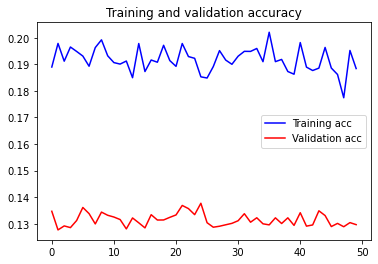

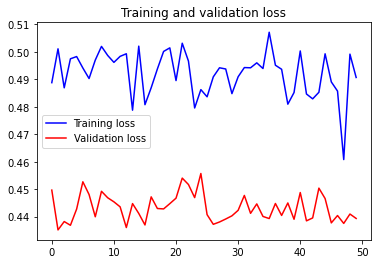

3/3 [==============================] - 0s 4ms/step


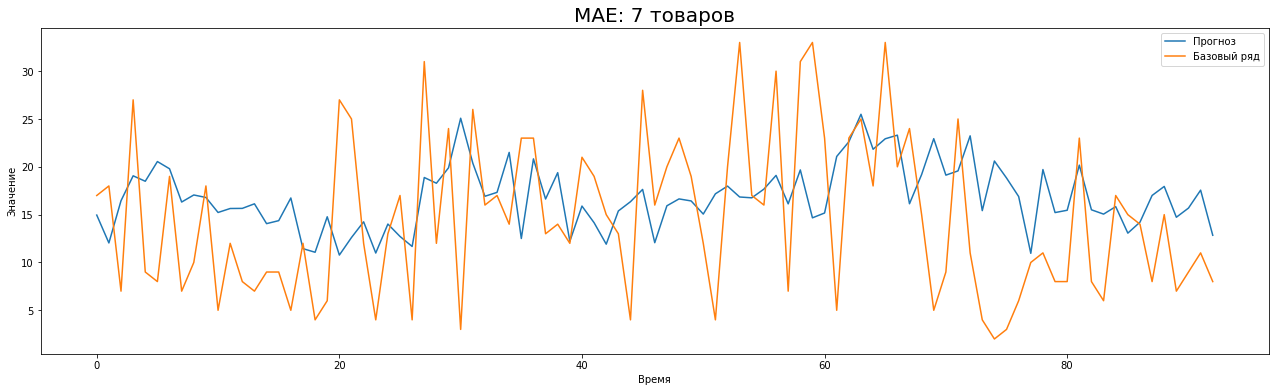

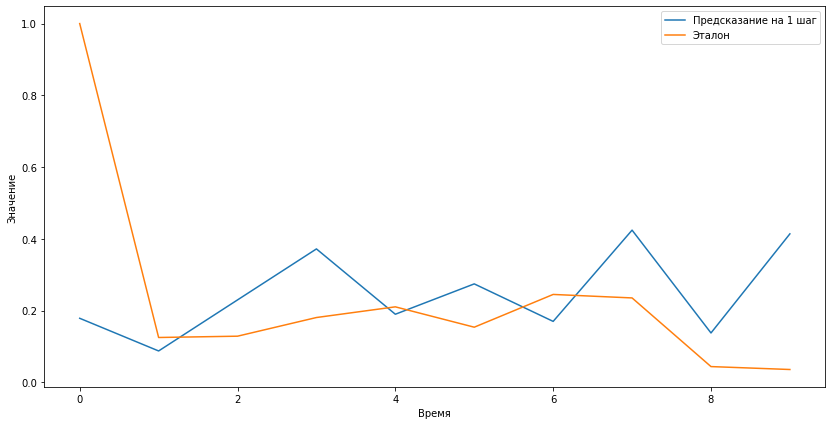

In [237]:
get_inf(model_C2, 200, 10, Scaler, x_test.values, y_test.values)

## Prediction for seven steps in a row?

In [550]:
def create_gen(data_series): 

    y_gen = np.concatenate((data_series,np.array([1,1,1,1,1,1,1])))
    print(y_gen[-50:], '- последние 50 элементов массива, дополненного семью единицами (7 дней недели)')
    print(y_gen.shape, '- размерность данного массива')

    y_tr = np.array([[y_gen[i], y_gen[i+1], y_gen[i+2], y_gen[i+3], y_gen[i+4], y_gen[i+5], y_gen[i+6]] for i,x in enumerate(data_series)])

    print(y_tr, '- массив таргетов для подачи в TimeseriesGenerator')
    print(y_tr.shape, '- размерность данного масива')

    x_train = data_series[:-6] # Создаем x_train
    y_train = y_tr[:-6] # Создаем y_train

    # Создаем генератор
    gen = TimeseriesGenerator(
        x_train,
        y_train,
        length= 28,       # длина окна
        sampling_rate=1,  # указывает интервал значений в выборке если 2, то (1,2,3,4)->(2,4)
        stride=1,         # шаг окна
        batch_size=1
        )
    
    return gen

In [551]:
gen1 = create_gen(data_quantity.quantity)

[12  4 20 33 17 16 30  7 31 33 23  5 23 25 18 33 20 24 15  5  9 25 11  4
  2  3  6 10 11  8  8 23  8  6 17 15 14  8 15  7  9 11  8  1  1  1  1  1
  1  1] - последние 50 элементов массива, дополненного семью единицами (7 дней недели)
(368,) - размерность данного массива
[[ 9 37 30 ... 38 47 35]
 [37 30 34 ... 47 35 22]
 [30 34 38 ... 35 22 68]
 ...
 [ 9 11  8 ...  1  1  1]
 [11  8  1 ...  1  1  1]
 [ 8  1  1 ...  1  1  1]] - массив таргетов для подачи в TimeseriesGenerator
(361, 7) - размерность данного масива


In [553]:
for i, g in enumerate(gen1):
    if i%100 == 0:
        print('Батч №', i)
        print('x_train:', g[0])
        print('y_train:', g[1])
        print()

Батч № 0
x_train: [[ 9 37 30 34 38 47 35 22 68 52 37 45 63 42 39 64 37 49 44 71 43 49 33 53
  58 38 92 39]]
y_train: [[38 50 59 47 60 73 43]]

Батч № 100
x_train: [[27  9  6  8  0  0  0  0  0  0 10 32 46 25 22 37 54 44 20 35 54 43 39 32
  55 40 32 32]]
y_train: [[22 36 35 34 48 27 27]]

Батч № 200
x_train: [[24 12 16 19 22 20 24 29 15 26 12 19 13 20 13 22 19  4 15 20  7 10 11 21
  20 21 14 13]]
y_train: [[13 17 14 20 19 12 28]]

Батч № 300
x_train: [[16 17 14 23 23 13 14 12 21 19 15 13  4 28 16 20 23 19 12  4 20 33 17 16
  30  7 31 33]]
y_train: [[23  5 23 25 18 33 20]]



### Хотелось попробовать предсказывать на 7 шагов подряд, но результаты моделей при предсказании всего одного значения далеки от совершенства, а данная задача куда сложнее. И визуализировать результаты было бы не так просто. Однако интересная мысля :)

# Final Prediction

In [488]:
####################################################
# Функция подготовки данных для финального прогноза.
####################################################

def prepareData(data, test_size, wimdow):

    data = data.copy()   
    data.columns = ['y']

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # Производим нормализацию. Scaler обучаем только на обучающих данных, т.к. это неизвестные данные для модели.
    Scaler = StandardScaler()
    normal_train = Scaler.fit_transform(data.iloc[:test_index].values.reshape(-1,1)) # fit_transform!
    normal_test = Scaler.transform(data.iloc[test_index:].values.reshape(-1,1))      # просто transform!
    data.iloc[:test_index] = normal_train
    data.iloc[test_index:] = normal_test
    
    
    # Изменение произошло только здесь :)
    for i in range(wimdow-1, 0-1, -1):
        data[f'{i} day ago'] = data.y.shift(i)
   
    # Избавляемся от NaN и сбрасываем индексный столбец до простых range индексов
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:test_index].drop(["y"], axis=1)
    y_train = data.iloc[:test_index]["y"]
    X_test = data.iloc[test_index:].drop(["y"], axis=1)
    y_test = data.iloc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test, Scaler



In [489]:
x_train, x_test, y_train, y_test, Scaler = prepareData(data_quantity, test_size=0.3, wimdow=10)

final_test = x_test[-7:]
final_test

,9 day ago,8 day ago,7 day ago,6 day ago,5 day ago,4 day ago,3 day ago,2 day ago,1 day ago,0 day ago
345,-1.373978,-1.311036,-1.499862,-1.499862,-0.555736,-1.499862,-1.625745,-0.933386,-1.059269,-1.122211
346,-1.311036,-1.499862,-1.499862,-0.555736,-1.499862,-1.625745,-0.933386,-1.059269,-1.122211,-1.499862
347,-1.499862,-1.499862,-0.555736,-1.499862,-1.625745,-0.933386,-1.059269,-1.122211,-1.499862,-1.059269
348,-1.499862,-0.555736,-1.499862,-1.625745,-0.933386,-1.059269,-1.122211,-1.499862,-1.059269,-1.562803
349,-0.555736,-1.499862,-1.625745,-0.933386,-1.059269,-1.122211,-1.499862,-1.059269,-1.562803,-1.436920
350,-1.499862,-1.625745,-0.933386,-1.059269,-1.122211,-1.499862,-1.059269,-1.562803,-1.436920,-1.311036
351,-1.625745,-0.933386,-1.059269,-1.122211,-1.499862,-1.059269,-1.562803,-1.436920,-1.311036,-1.499862


1/1 [==============================] - 0s 29ms/step


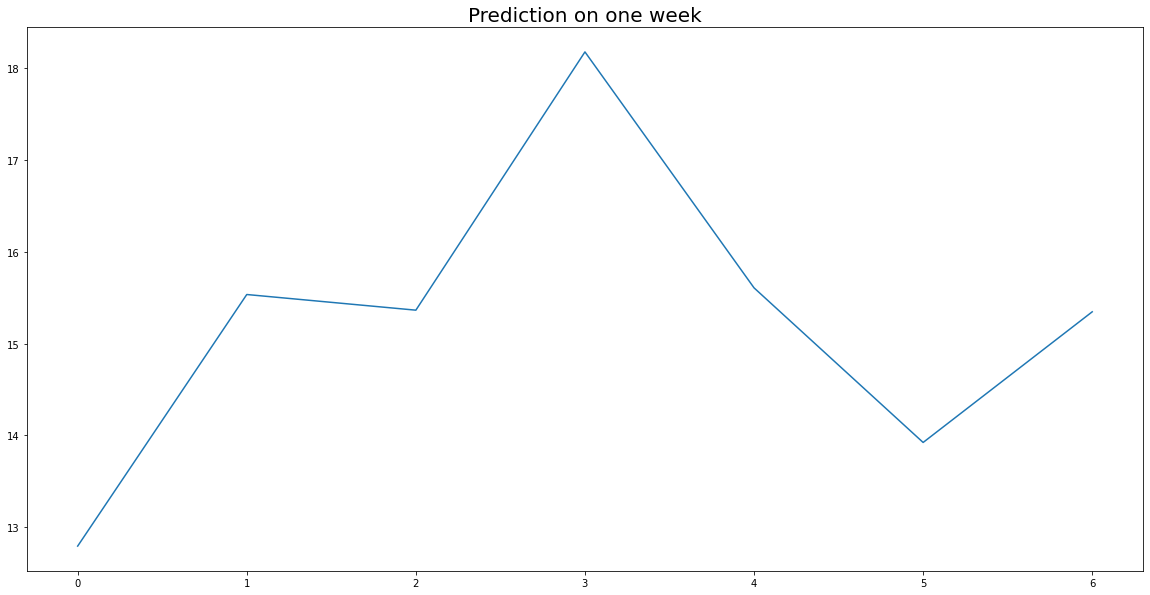

In [494]:
###############################
# Отображаем финальный прогноз.
###############################

predictions = model_C1.predict(final_test, verbose=1)
pred = Scaler.inverse_transform(predictions)

plt.figure(figsize=(20,10))
plt.plot(pred)
plt.title('Prediction on one week', fontsize=20)
plt.show()

In [507]:
date =  pd.date_range('2021/12/31', periods = 7, freq ='d')
date

DatetimeIndex(['2021-12-31', '2022-01-01', '2022-01-02', '2022-01-03',
               '2022-01-04', '2022-01-05', '2022-01-06'],
              dtype='datetime64[ns]', freq='D')

In [516]:
pred_round = np.around(pred, decimals=0, out=None)
pred_round

array([[13.],
       [16.],
       [15.],
       [18.],
       [16.],
       [14.],
       [15.]], dtype=float32)

In [519]:
answer = pd.DataFrame({'dates':date, 'quantities':pred_round.reshape(7)}, index=None)
answer

,dates,quantities
0,2021-12-31,13.0
1,2022-01-01,16.0
2,2022-01-02,15.0
3,2022-01-03,18.0
4,2022-01-04,16.0
5,2022-01-05,14.0
6,2022-01-06,15.0


In [521]:
answer.to_csv('C:/Users/user/Desktop/Employers/Imprice/one_week_prediction.csv', index=False)